
# Figure 1 (g500, 1008 dataset): 4×3 Grid of Sample Events

This notebook:
- Reads the **1008 g500** dataset CSVs (train/val).

In [1]:
import sys, os

# Get the absolute path of the parent folder (where config.py lives)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print("Added to sys.path:", parent_dir)

Added to sys.path: /home/arsalan/wsu-grid/ml-jet-param-predictor


In [2]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.resume import load_pretrained_model
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [3]:


from models.model_vit import create_model
cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
"experiments/exp_plotting_event_aggregation_evolotion/config/" \
"vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml")

# from models.model_mamba import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_alpha_s_evaluation_with_vit/config/" \
# "vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds7200000_g500_sched-RLRP_preload_p4.yml")

# cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_plotting_event_aggregation_evolotion/config/vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4",
  "backbone": "vit_gaussian",
  "batch_size": 32,
  "epochs": 50,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
  "train_csv": "/home/arsalan/Projects/1

In [4]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")


[INFO] Saving all outputs to: experiments/exp_plotting_sample_g500_events/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded


In [5]:
device= get_device_summary()

=== NVIDIA-SMI ===
Fri Sep 12 13:43:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P5              26W / 220W |    672MiB /  8192MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [6]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 26
[INFO] Length of validation dataloader: 4
[INFO] Length of test dataloader: 4



- Picks **one sample** for each combination of **$Q_0 \in \{1.0, 1.5, 2.0, 2.5\}$** and **$\alpha_s \in \{0.2, 0.3, 0.4\}$**.
- Builds a **4×3** montage image (rows = $Q_0$; cols = $\alpha_s$) **without subplots** by composing tiles with PIL.
- Saves `figure1_g500_4x3.png` and shows it via a single `imshow` call (no seaborn, no custom colors).


In [7]:
def plot_avg_hist2d(entry, dataset_root, global_max=121.79151153564453):
    import numpy as np
    imgs = [
        np.load(os.path.join(dataset_root, p)).astype(np.float32)/global_max
        for p in entry['file_paths'].split('|')
    ]
    avg = np.mean(imgs, axis=0)
    avg_masked = np.ma.masked_where(avg==0, avg)
    return avg_masked

In [41]:
sizes1=(1,2,4,8,16,32,64,128,256,500)
sizes2=(1,4,10,16,25,32,50,75,100,150,200,300,400,500)
sizes3=(1,2,4,8,10,16,25,32,50,64,100,125,128,200,256,300,400,500)


[evolution] shared log color scale: vmin=1.000e-06, vmax=2.794e-01


/tmp/ipykernel_26393/1845104124.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


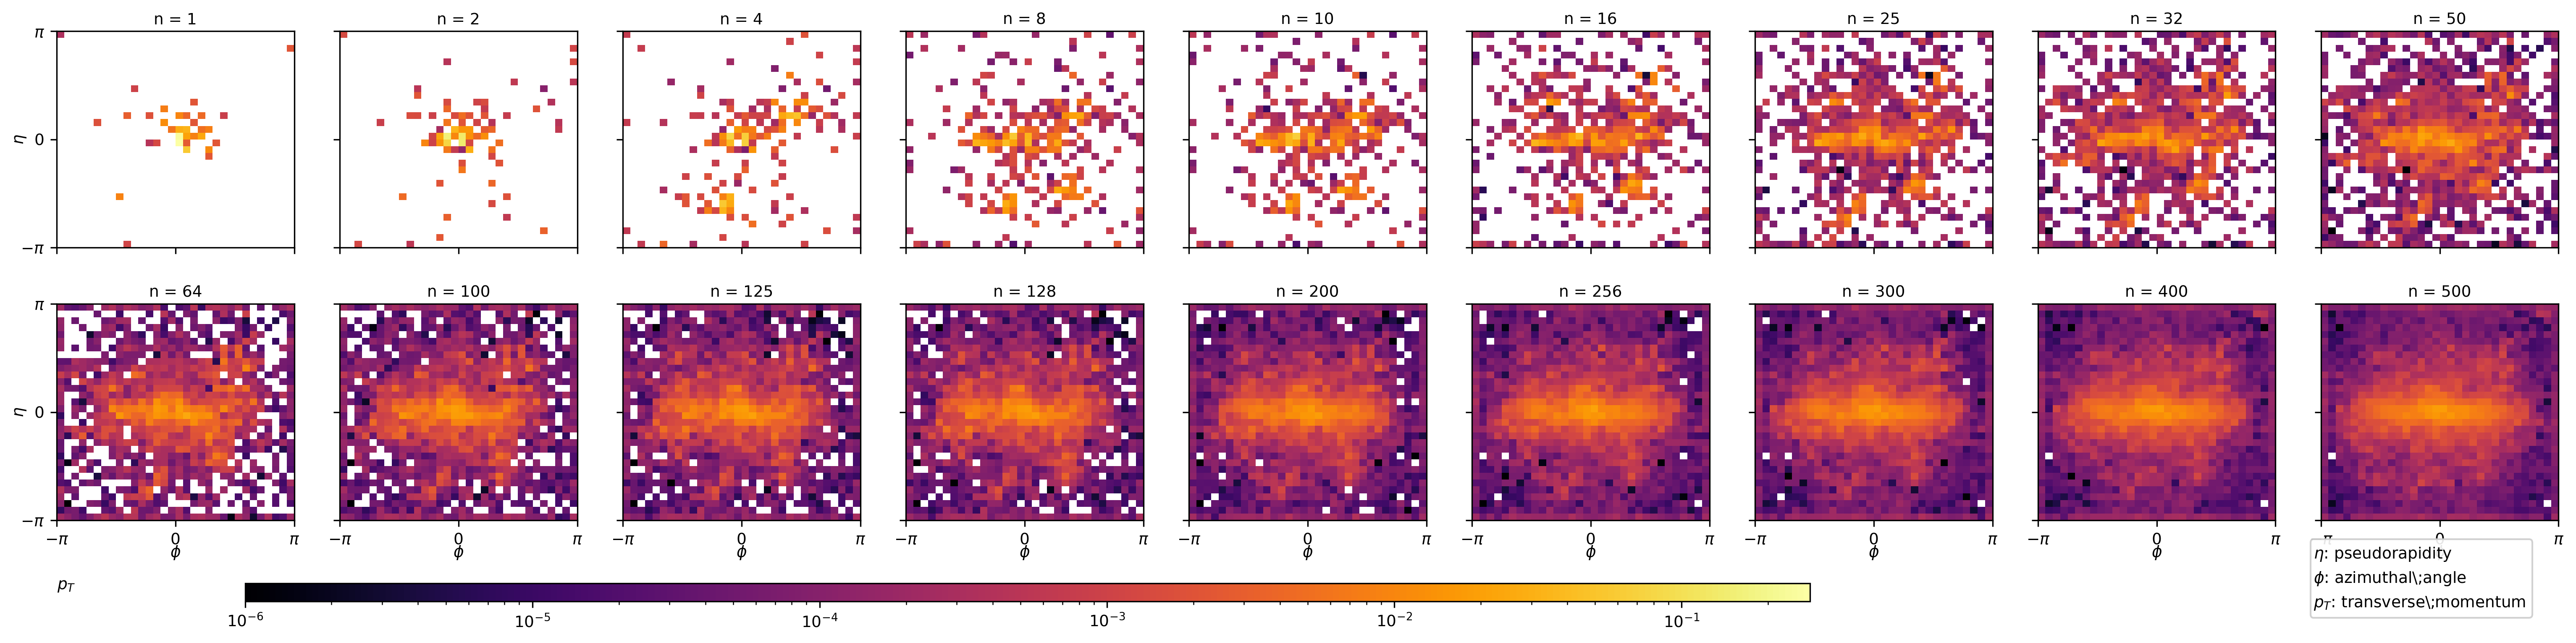

In [44]:
def plot_evolution_hist2d_for_cell(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    global_max=121.79151153564453,
    alpha_idx=0,          # 0->0.2, 1->0.3, 2->0.4
    q0_idx=0,             # 0->1.0, 1->1.5, 2->2.0, 3->2.5
    module_value=None,    # None, "MATTER", or "MATTER-LBT"
    sizes=sizes3,
    random_state=0
):
    """
    Build a 2x5 grid showing the evolution from a single event to an average over 500 events.
    We gather raw .npy paths from multiple aggregated rows (same labels) until we have >= max(sizes).
    """
    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.patches as mpatches

    # ---- label maps
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    energy_inv = {v: k for k, v in energy_map.items()}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    # ---- load CSV and filter rows matching the chosen cell
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv_path = os.path.join(dataset_root, agg_csv)
    df = pd.read_csv(agg_csv_path)

    mask = (df['alpha'] == alpha_idx) & (df['q0'] == q0_idx)
    if module_value is not None:
        mask &= df['energy_loss'] == energy_inv[module_value]
    df_cell = df[mask].sample(frac=1.0, random_state=random_state)  # shuffle for randomness
    if df_cell.empty:
        raise ValueError("No entries found for the requested (alpha, q0, module).")

    # ---- collect raw file paths until we have enough to cover 'sizes'
    need = max(sizes)
    file_list = []
    for _, row in df_cell.iterrows():
        # each row has a '|' separated list of raw event .npy files
        paths = [os.path.join(dataset_root, p) for p in row['file_paths'].split('|')]
        file_list.extend(paths)
        if len(file_list) >= need:
            break
    if len(file_list) < need:
        raise ValueError(f"Only found {len(file_list)} files, fewer than requested {need}.")

    # ---- load the first 'need' images and normalize; build cumulative averages efficiently
    #     imgs shape: (need, 32, 32); use float32 to keep memory small
    imgs = []
    for p in file_list[:need]:
        arr = np.load(p).astype(np.float32) / float(global_max)
        imgs.append(arr)
    imgs = np.stack(imgs, axis=0)  # (N,H,W)
    cumsum = np.cumsum(imgs, axis=0)  # cumulative sum for fast prefix means

    # ---- precompute all averaged images and shared color scale (ignoring zeros)
    avgs = []
    vmins, vmaxs = [], []
    for n in sizes:
        avg = cumsum[n-1] / float(n)
        avg = np.ma.masked_where(avg == 0, avg)
        avgs.append(avg)
        # compute robust min>0 and max for log scale
        has_pos = np.any(avg > 0)
        mn = np.min(avg[avg > 0]) if has_pos else 1e-6
        mx = np.max(avg) if has_pos else 1.0
        vmins.append(max(mn, 1e-6))
        vmaxs.append(mx)

    vmin = min(vmins) if vmins else 1e-6
    vmax = max(vmaxs) if vmaxs else 1.0
    print(f"[evolution] shared log color scale: vmin={vmin:.3e}, vmax={vmax:.3e}")

    # ---- plotting
    # grid: 2 rows x 5 cols for 10 panels
    nrows, ncols = 2, 9
    assert len(sizes) == nrows * ncols, "sizes must have length 10 (e.g., 1..256 plus 500)."

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(ncols*2.3, nrows*2.4), dpi=300, sharex=True, sharey=True
    )

    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    last_pcm = None
    for idx, n in enumerate(sizes):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        ax.set_xticks([]); ax.set_yticks([])
        pcm = ax.pcolormesh(
            x_edges, y_edges, avgs[idx],
            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap='inferno', shading='auto'
        )
        last_pcm = pcm
        ax.set_title(f"n = {n}", fontsize=9, pad=4)

    # outer ticks / labels on leftmost and bottom axes
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=9)
        ax.set_ylabel(r'$\eta$', fontsize=9, rotation=90, labelpad=-4)
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=9)
        ax.set_xlabel(r'$\phi$', fontsize=9, labelpad=-2)

    # row / figure annotations (which cell we are visualizing)
    alpha_str = alpha_vals[alpha_idx]
    q0_str = q0_vals[q0_idx]
    module_str = (module_value if module_value is not None
                  else energy_map[int(df_cell.iloc[0]['energy_loss'])])
    # fig.suptitle(f"Evolution of averaged Hist2D: αₛ={alpha_str}, Q₀={q0_str}, module={module_str}",
    #              fontsize=11, y=0.99)

    # bottom colorbar
    if last_pcm is not None:
        cax = fig.add_axes([0.10, -0.02, 0.60, 0.03])
        cbar = fig.colorbar(last_pcm, cax=cax, orientation='horizontal', location='bottom')
        cbar.ax.set_title(r"$p_T$", fontsize=9, pad=6, loc='left', x=-0.12, y=0.1)
        cbar.ax.tick_params(labelsize=9)

    # legend with symbol explanations
    legend_elements = [
        mpatches.Patch(color='none', label=r"$\eta$: pseudorapidity"),
        mpatches.Patch(color='none', label=r"$\phi$: azimuthal\;angle"),
        mpatches.Patch(color='none', label=r"$p_T$: transverse\;momentum"),
    ]
    fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, -0.06),
               fontsize=9, frameon=True, framealpha=0.9, handlelength=0, handletextpad=-0.2)

    plt.tight_layout()

    # save
    base = f"evolution_hist2d_alpha{alpha_str}_q0{q0_str}_{module_str}".replace('.', 'p')
    fig.savefig(base + ".png", dpi=300, bbox_inches="tight")
    fig.savefig(base + ".pdf", bbox_inches="tight")
    plt.show()
#MATTER, α=0.2 (idx 0), Q0=1.0 (idx 0)
plot_evolution_hist2d_for_cell(alpha_idx=0, q0_idx=0, module_value="MATTER")

[evolution] shared log color scale: vmin=1.000e-06, vmax=3.486e-01


/tmp/ipykernel_26393/1845104124.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


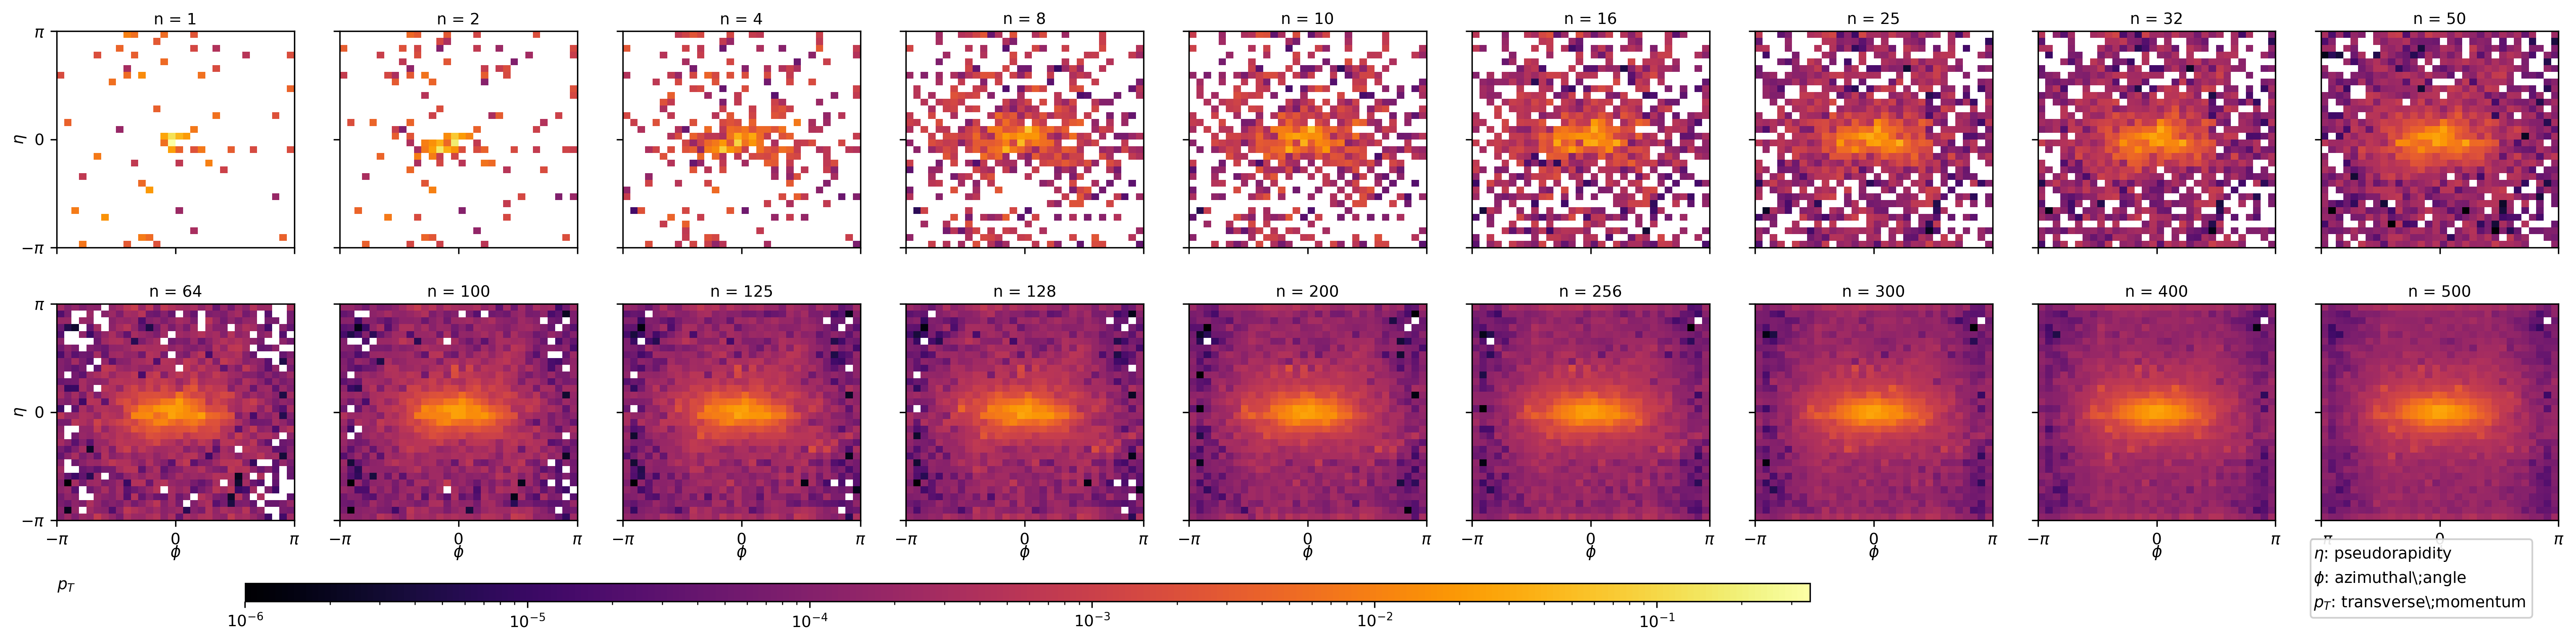

In [45]:
# MATTER-LBT, α=0.4 (idx 2), Q0=2.5 (idx 3)
plot_evolution_hist2d_for_cell(alpha_idx=2, q0_idx=3, module_value="MATTER-LBT")

In [57]:
def plot_evolution_hist2d_for_cell(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    global_max=121.79151153564453,
    alpha_idx=0, q0_idx=0, module_value=None,
    sizes=sizes2,
    layout="2x5",           # "2x5" (default) or "1xN"
    random_state=0,
    cmap='inferno',
    add_axes_labels=True,
    add_legend=True,
    add_colorbar=True,
    add_events_count_as_title=True,
):
    import os, math
    import numpy as np, pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.patches as mpatches

    energy_map = {0:'MATTER',1:'MATTER-LBT'}
    energy_inv = {v:k for k,v in energy_map.items()}
    alpha_vals = {0:0.2,1:0.3,2:0.4}
    q0_vals    = {0:1.0,1:1.5,2:2.0,3:2.5}

    dataset_root = os.path.expanduser(dataset_root)
    df = pd.read_csv(os.path.join(dataset_root, agg_csv))
    mask = (df['alpha']==alpha_idx) & (df['q0']==q0_idx)
    if module_value is not None:
        mask &= df['energy_loss']==energy_inv[module_value]
    df_cell = df[mask].sample(frac=1.0, random_state=random_state)
    if df_cell.empty:
        raise ValueError("No entries for requested (alpha,q0,module).")

    need = max(sizes)
    files=[]
    for _,row in df_cell.iterrows():
        files += [os.path.join(dataset_root,p) for p in row['file_paths'].split('|')]
        if len(files)>=need: break
    if len(files)<need:
        raise ValueError(f"Found {len(files)} files, fewer than {need} requested.")

    imgs = np.stack([np.load(p).astype(np.float32)/float(global_max) for p in files[:need]], axis=0)
    cumsum = np.cumsum(imgs, axis=0)

    avgs=[]; vmins=[]; vmaxs=[]
    for n in sizes:
        a = cumsum[n-1]/float(n)
        a = np.ma.masked_where(a==0, a)
        avgs.append(a)
        if np.any(a>0):
            vmins.append(max(np.min(a[a>0]),1e-6)); vmaxs.append(np.max(a))
        else:
            vmins.append(1e-6); vmaxs.append(1.0)
    vmin, vmax = min(vmins), max(vmaxs)

    # --- layout ---
    if layout.lower()=="1xn":
        nrows, ncols = 1, len(sizes)
        figsize = (ncols*2.2, 2.6)
    else:
        nrows, ncols = 2, 5
        assert len(sizes)==nrows*ncols, "sizes must match grid"
        figsize = (ncols*2.3, nrows*2.4)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=300, sharex=True, sharey=True)
    if nrows==1:
        axes = np.atleast_2d(axes)  # shape (1, ncols)

    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    last_pcm=None
    for i,n in enumerate(sizes):
        r, c = (i//ncols, i%ncols)
        ax = axes[r, c]
        ax.set_xticks([]); ax.set_yticks([])
        pcm = ax.pcolormesh(x_edges, y_edges, avgs[i],
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                            cmap=cmap, shading='auto')
        last_pcm = pcm
        if add_events_count_as_title:
            ax.set_title(f"n = {n}", fontsize=9, pad=4)
    if add_axes_labels:
        # axes labels only on outer edges
        for ax in axes[:,0]:
            ax.set_yticks([-math.pi,0,math.pi])
            ax.set_yticklabels([r'$-\pi$','0',r'$\pi$'], fontsize=9)
            ax.set_ylabel(r'$\eta$', fontsize=9, labelpad=-4)
        for ax in axes[-1,:]:
            ax.set_xticks([-math.pi,0,math.pi])
            ax.set_xticklabels([r'$-\pi$','0',r'$\pi$'], fontsize=9)
            ax.set_xlabel(r'$\phi$', fontsize=9, labelpad=-2)

    alpha_str, q0_str = alpha_vals[alpha_idx], q0_vals[q0_idx]
    module_str = module_value if module_value is not None else energy_map[int(df_cell.iloc[0]['energy_loss'])]
    # fig.suptitle(f"Evolution of averaged Hist2D: αₛ={alpha_str}, Q₀={q0_str}, module={module_str}",
    #              fontsize=11, y=0.99)

    # colorbar under the figure; make it a bit wider for 1xN
    if (last_pcm is not None) and add_colorbar:
        if nrows==1:
            cax = fig.add_axes([0.03, -0.06, 0.8, 0.04])
        else:
            cax = fig.add_axes([0.10, -0.02, 0.60, 0.03])
        cbar = fig.colorbar(last_pcm, cax=cax, orientation='horizontal', location='bottom')
        cbar.ax.set_title(r"$p_T$", fontsize=9, pad=6, loc='left', x=-0.02, y=0.14)
        cbar.ax.tick_params(labelsize=9)

    if add_legend:
        legend_elements = [
            mpatches.Patch(color='none', label=r"$\eta$: pseudorapidity     $p_T$: transverse momentum"),
            mpatches.Patch(color='none', label=r"$\phi$: azimuthal angle   $n$: number of events"),
            # mpatches.Patch(color='none', label=r"$p_T$: transverse momentum"),
        ]
        fig.legend(handles=legend_elements, loc='lower right',
                bbox_to_anchor=(0.995, -0.15 if nrows==1 else -0.06),
                fontsize=9, frameon=True, framealpha=0.9, handlelength=0, handletextpad=-0.2)

    plt.tight_layout()
    base = f"evolution_hist2d_alpha{str(alpha_str).replace('.','p')}_q0{str(q0_str).replace('.','p')}_{module_str}"
    fig.savefig(base + ("_1xN" if nrows==1 else "_2x5") + ".png", dpi=300, bbox_inches="tight")
    fig.savefig(base + ("_1xN" if nrows==1 else "_2x5") + ".pdf", bbox_inches="tight")
    plt.show()


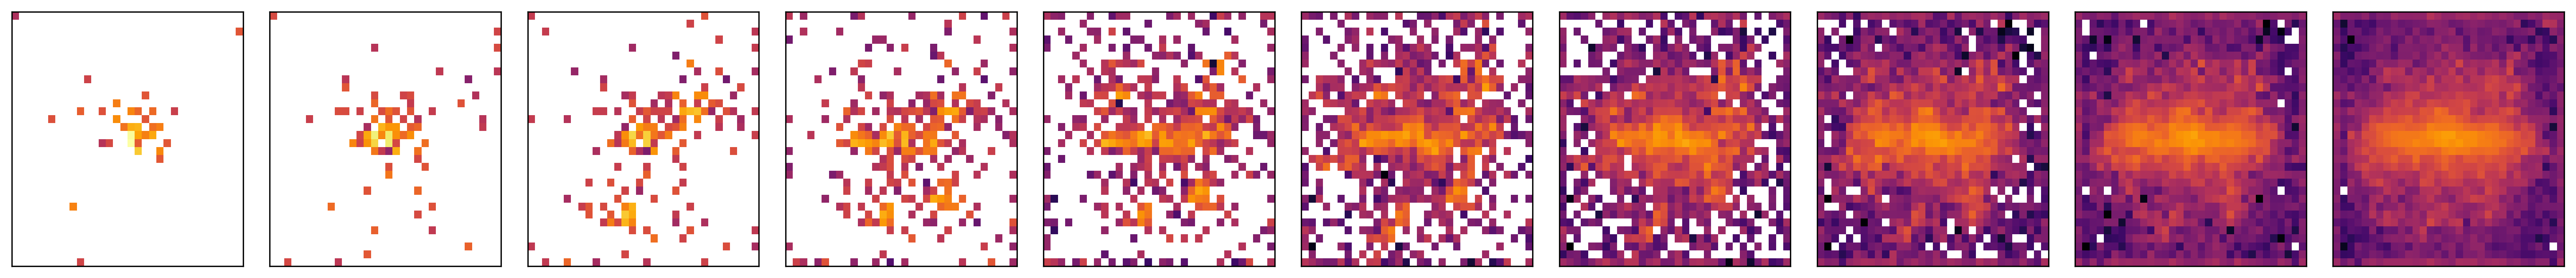

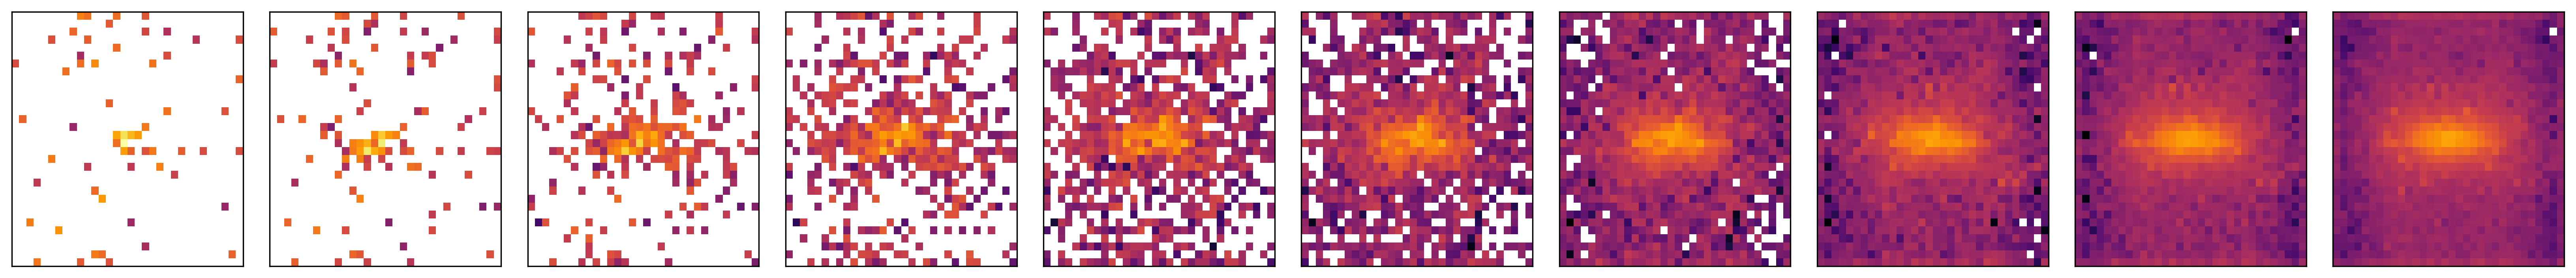

In [58]:
plot_evolution_hist2d_for_cell(
    alpha_idx=0, q0_idx=0, module_value="MATTER",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False,
    add_axes_labels=False,
    add_events_count_as_title=False
)
plot_evolution_hist2d_for_cell(
    alpha_idx=2, q0_idx=3, module_value="MATTER-LBT",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False,
    add_axes_labels=False,
    add_events_count_as_title=False
)

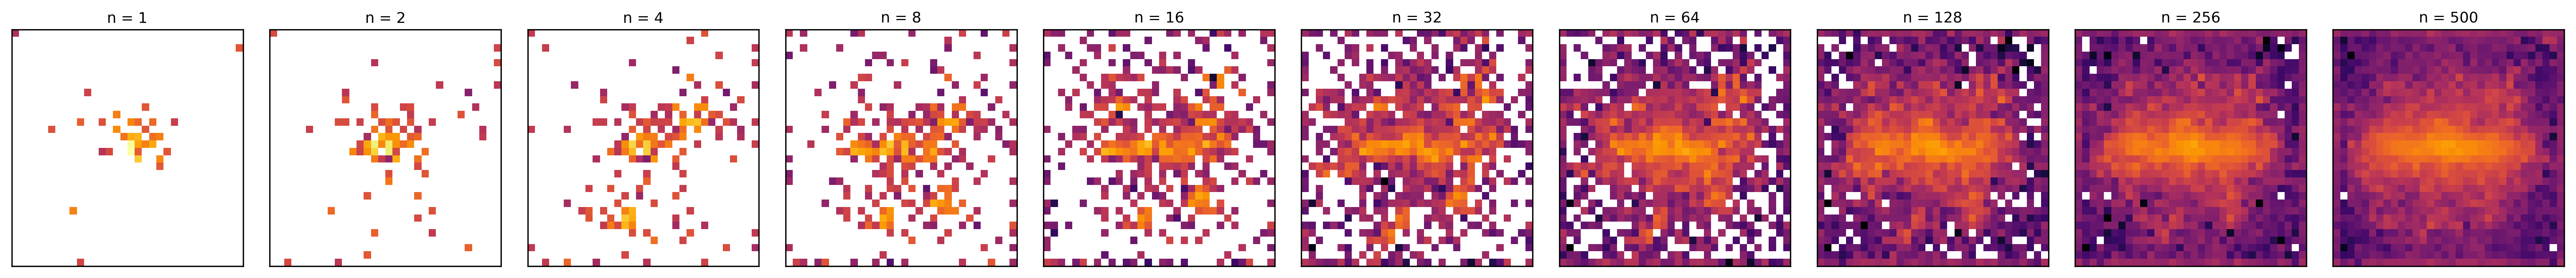

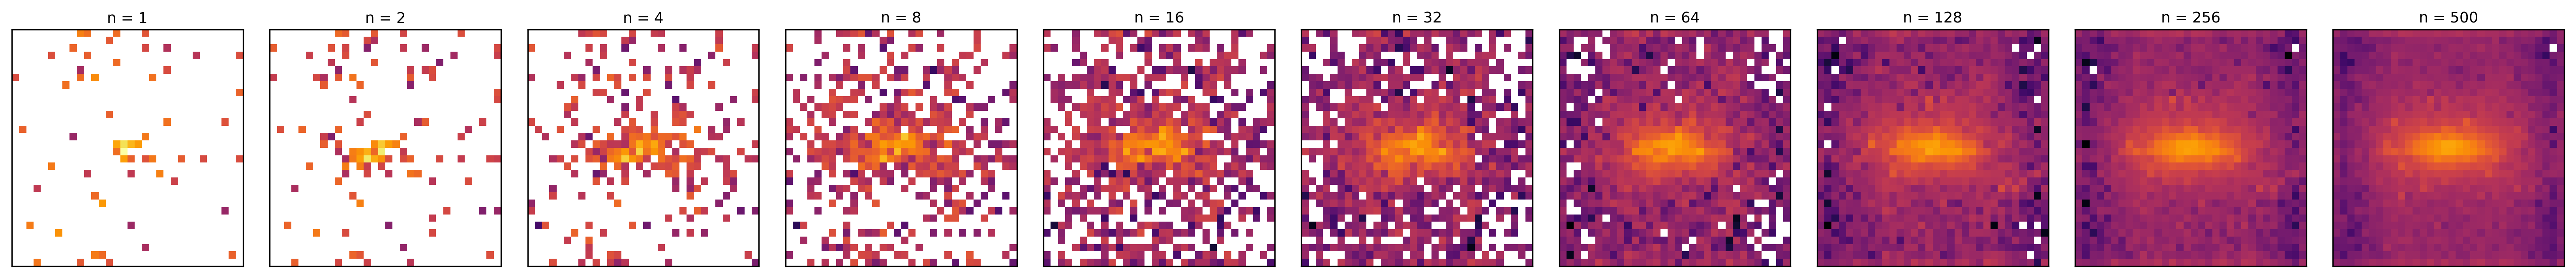

In [55]:
plot_evolution_hist2d_for_cell(
    alpha_idx=0, q0_idx=0, module_value="MATTER",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False,
    add_axes_labels=False
)
plot_evolution_hist2d_for_cell(
    alpha_idx=2, q0_idx=3, module_value="MATTER-LBT",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False,
    add_axes_labels=False
)

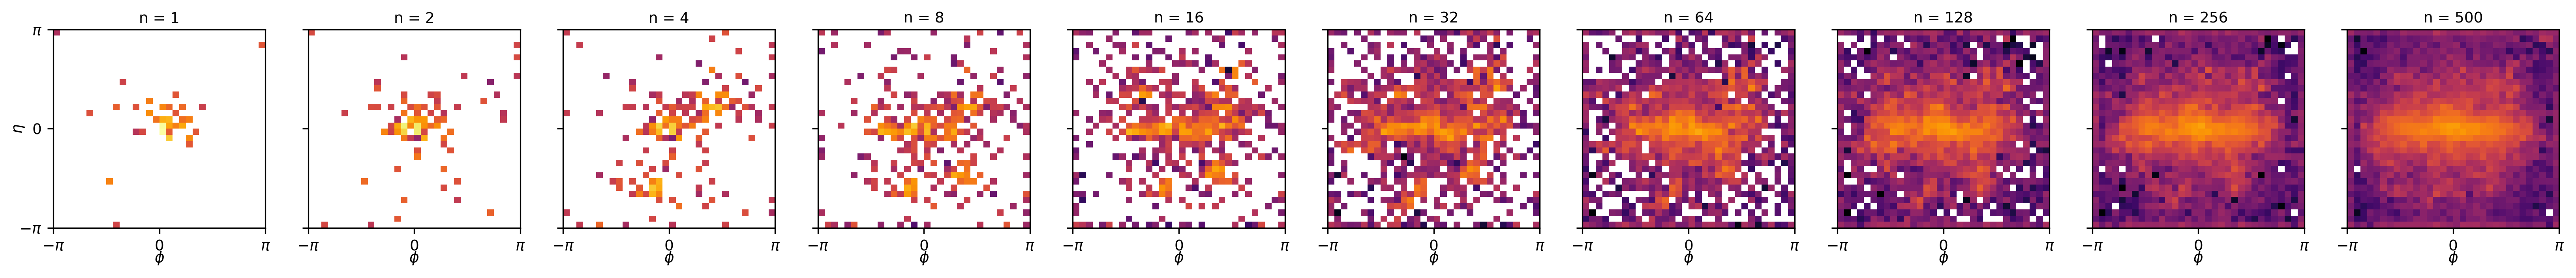

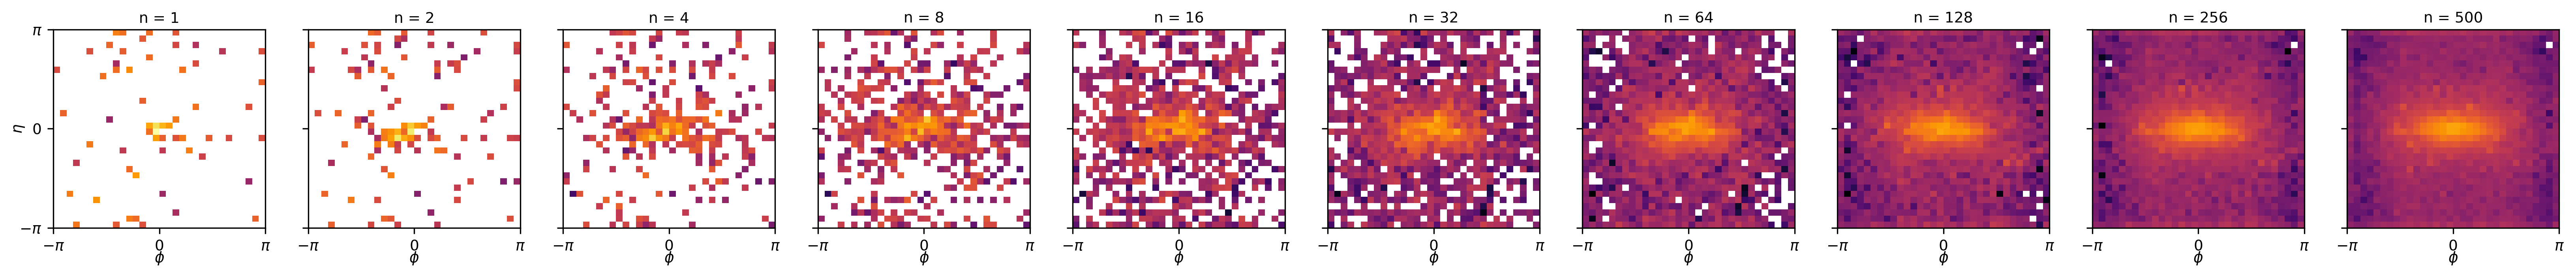

In [52]:
plot_evolution_hist2d_for_cell(
    alpha_idx=0, q0_idx=0, module_value="MATTER",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False
)
plot_evolution_hist2d_for_cell(
    alpha_idx=2, q0_idx=3, module_value="MATTER-LBT",
    sizes=sizes1,
    layout="1xN",
    add_legend=False,
    add_colorbar=False
)


/tmp/ipykernel_26393/3382057407.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


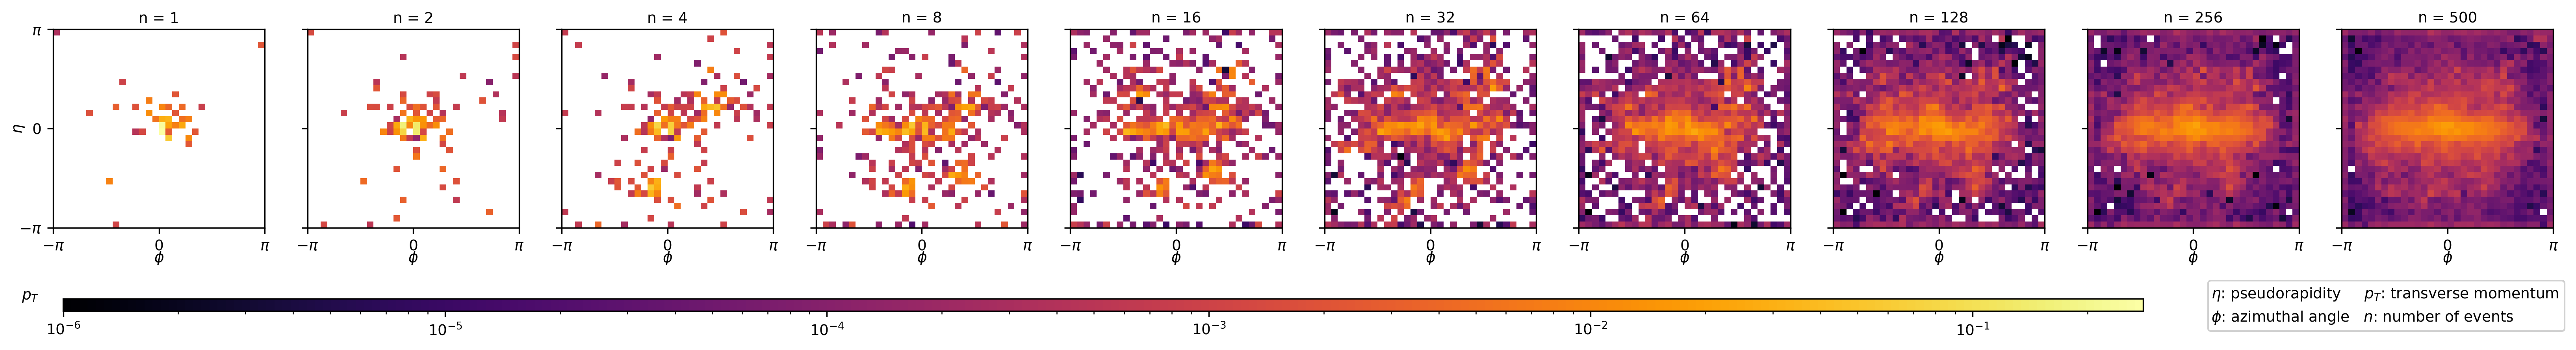

/tmp/ipykernel_26393/3382057407.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


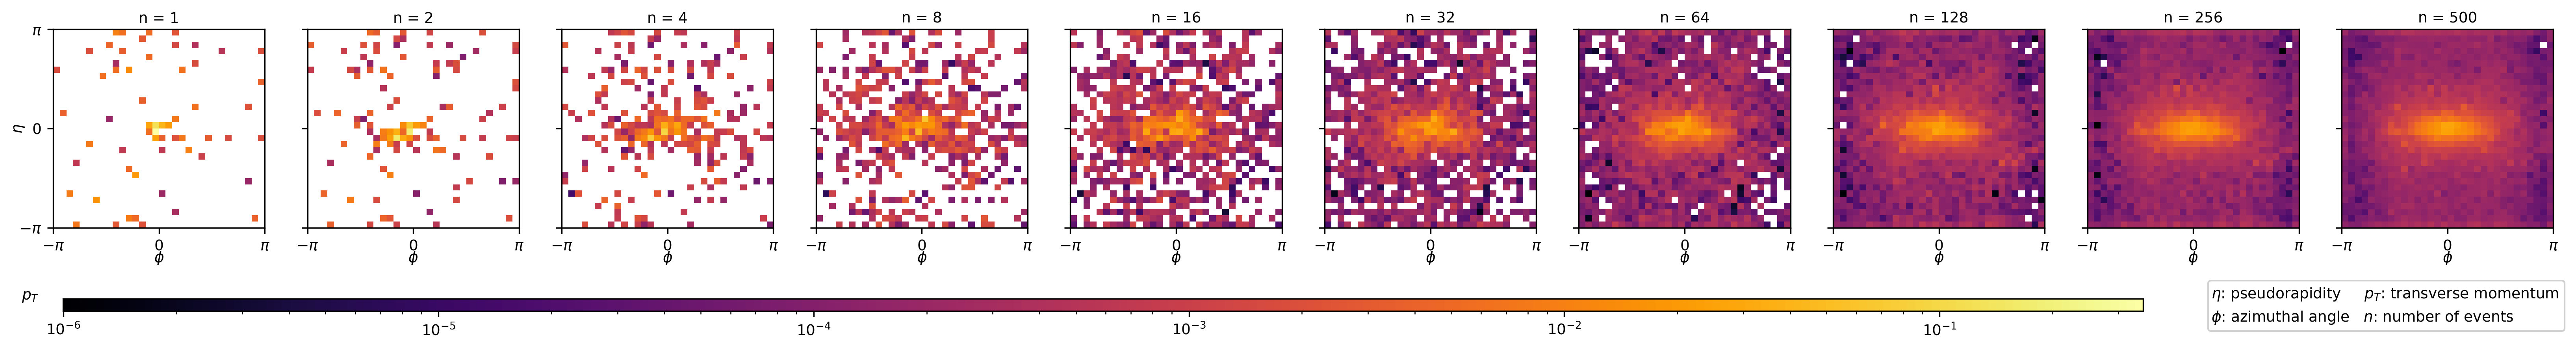

In [48]:
plot_evolution_hist2d_for_cell(
    alpha_idx=0, q0_idx=0, module_value="MATTER",
    sizes=sizes1,
    layout="1xN"
)
plot_evolution_hist2d_for_cell(
    alpha_idx=2, q0_idx=3, module_value="MATTER-LBT",
    sizes=sizes1,
    layout="1xN"
)

/tmp/ipykernel_26393/3975549839.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


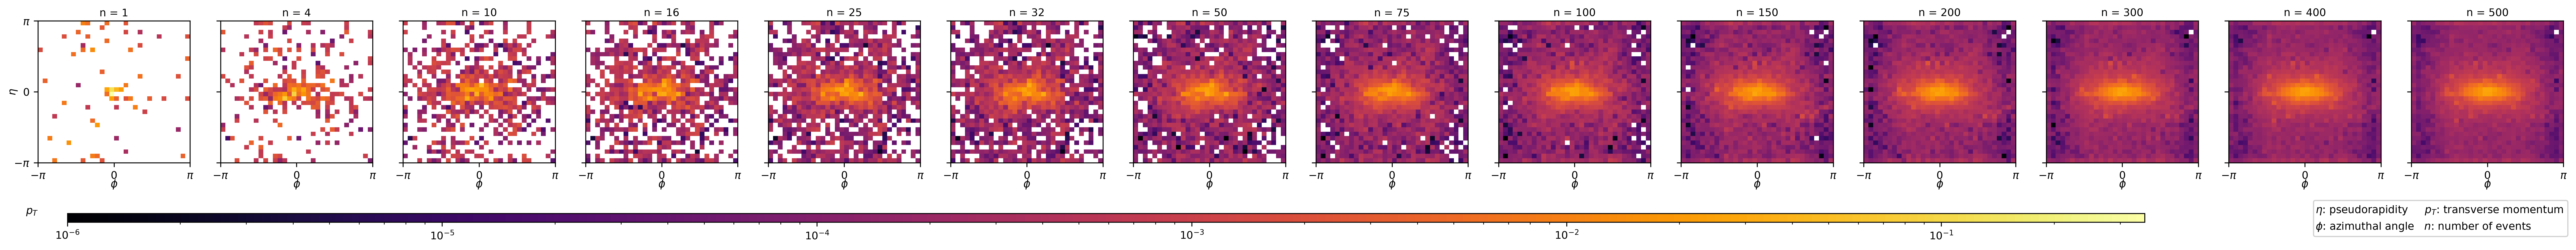

In [ ]:
plot_evolution_hist2d_for_cell(
    alpha_idx=2, q0_idx=3, module_value="MATTER-LBT",
    sizes=,
    layout="1xN"
)

In [ ]:
def plot_grid_hist2d_artistic(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    module_value=None,                # None, "MATTER", "MATTER-LBT"
    global_max=121.79151153564453,
    cmap="inferno",
    background="black",               # "black" or "white"
    keep_colorbar=False,              # True for a thin bar, False for pure abstract
    random_state=0,
):
    import os, math
    import numpy as np, pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # label maps
    energy_map = {0:'MATTER', 1:'MATTER-LBT'}
    energy_inv = {v:k for k,v in energy_map.items()}
    alpha_vals = {0:0.2,1:0.3,2:0.4}
    q0_vals    = {0:1.0,1:1.5,2:2.0,3:2.5}

    # load
    dataset_root = os.path.expanduser(dataset_root)
    df = pd.read_csv(os.path.join(dataset_root, agg_csv))
    if module_value is not None:
        df = df[df['energy_loss'] == energy_inv[module_value]]

    alphas = [0,1,2]
    q0s    = [0,1,2,3]
    n_rows, n_cols = len(q0s), len(alphas)

    # figure — large for “gallery” feel
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols*3.0, n_rows*3.0), dpi=300,
        sharex=True, sharey=True
    )

    # backgrounds
    if background.lower() == "black":
        fig.patch.set_facecolor("black")
        for ax in axes.ravel(): ax.set_facecolor("black")
        fg = "white"
    else:
        fig.patch.set_facecolor("white")
        for ax in axes.ravel(): ax.set_facecolor("white")
        fg = "black"

    # bins (fixed)
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    # collect and scale
    imgs, vmins, vmaxs = [], [], []
    cell = [[None]*n_cols for _ in range(n_rows)]
    rng = np.random.RandomState(random_state)

    def _avg(entry):
        paths = [os.path.join(dataset_root, p) for p in entry['file_paths'].split('|')]
        arrs  = [np.load(p).astype(np.float32)/global_max for p in paths]
        avg = np.mean(arrs, axis=0)
        return np.ma.masked_where(avg==0, avg)

    for r, q in enumerate(q0s):
        for c, a in enumerate(alphas):
            subset = df[(df['alpha']==a) & (df['q0']==q)]
            if subset.empty: continue
            entry = subset.sample(n=1, random_state=rng).iloc[0]
            img = _avg(entry)
            cell[r][c] = img
            if np.any(img>0):
                vmins.append(max(np.min(img[img>0]), 1e-6))
                vmaxs.append(np.max(img))

    # shared log scale
    vmin = min(vmins) if vmins else 1e-6
    vmax = max(vmaxs) if vmaxs else 1.0

    last = None
    for r in range(n_rows):
        for c in range(n_cols):
            ax = axes[r, c]
            ax.axis("off")                     # <- minimalist
            if cell[r][c] is None: continue
            last = ax.pcolormesh(
                x_edges, y_edges, cell[r][c],
                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                cmap=cmap, shading='auto'
            )

    # optional ultra-thin colorbar
    if keep_colorbar and last is not None:
        cax = fig.add_axes([0.10, 0.02, 0.80, 0.015])  # thin, unobtrusive
        cbar = fig.colorbar(last, cax=cax, orientation='horizontal')
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(length=0, labelsize=8, colors=fg)

    plt.subplots_adjust(wspace=0.02, hspace=0.02)      # tight tiles
    base = f"jet_images_art_grid_4x3_{background}_{cmap}"
    fig.savefig(base + ".png", dpi=400, bbox_inches="tight", facecolor=fig.get_facecolor())
    fig.savefig(base + ".pdf", bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()

# 4×3 gallery, black background, inferno, no colorbar
plot_grid_hist2d_artistic(background="black", cmap="inferno", keep_colorbar=False)


In [ ]:
def plot_evolution_hist2d_artistic(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    alpha_idx=0, q0_idx=0, module_value=None,          # choose the cell
    global_max=121.79151153564453,
    sizes=,
    cmap="inferno",
    background="black",                                # "black" or "white"
    keep_colorbar=False,
    random_state=0
):
    import os, math
    import numpy as np, pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # label maps
    energy_map = {0:'MATTER', 1:'MATTER-LBT'}
    energy_inv = {v:k for k,v in energy_map.items()}

    # load & filter
    dataset_root = os.path.expanduser(dataset_root)
    df = pd.read_csv(os.path.join(dataset_root, agg_csv))
    mask = (df['alpha']==alpha_idx) & (df['q0']==q0_idx)
    if module_value is not None:
        mask &= df['energy_loss']==energy_inv[module_value]
    df_cell = df[mask].sample(frac=1.0, random_state=random_state)
    if df_cell.empty:
        raise ValueError("No entries found for the requested (alpha, q0, module).")

    need = max(sizes)
    files=[]
    for _, row in df_cell.iterrows():
        files += [os.path.join(dataset_root,p) for p in row['file_paths'].split('|')]
        if len(files) >= need: break
    if len(files) < need:
        raise ValueError(f"Only {len(files)} files available; need {need}.")

    # load & cumulative means
    imgs = np.stack([np.load(p).astype(np.float32)/global_max for p in files[:need]], axis=0)
    cumsum = np.cumsum(imgs, axis=0)
    avgs = [np.ma.masked_where((cumsum[n-1]/float(n))==0, cumsum[n-1]/float(n)) for n in sizes]

    # shared log scale
    posmins = []
    vmaxs = []
    for a in avgs:
        if np.any(a>0):
            posmins.append(max(np.min(a[a>0]), 1e-6))
            vmaxs.append(np.max(a))
    vmin = min(posmins) if posmins else 1e-6
    vmax = max(vmaxs)  if vmaxs  else 1.0

    # figure — very wide panoramic strip
    n = len(sizes)
    fig, axes = plt.subplots(1, n, figsize=(n*2.6, 2.8), dpi=300, sharex=True, sharey=True)

    # backgrounds
    if background.lower() == "black":
        fig.patch.set_facecolor("black")
        for ax in np.atleast_1d(axes): ax.set_facecolor("black")
        fg = "white"
    else:
        fig.patch.set_facecolor("white")
        for ax in np.atleast_1d(axes): ax.set_facecolor("white")
        fg = "black"

    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    last=None
    for i, ax in enumerate(np.atleast_1d(axes)):
        ax.axis("off")  # <- minimalist / no ticks, no titles
        last = ax.pcolormesh(
            x_edges, y_edges, avgs[i],
            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, shading='auto'
        )

    # optional thin colorbar
    if keep_colorbar and last is not None:
        cax = fig.add_axes([0.05, 0.05, 0.90, 0.02])
        cbar = fig.colorbar(last, cax=cax, orientation='horizontal')
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(length=0, labelsize=8, colors=fg)

    plt.subplots_adjust(wspace=0.02, hspace=0.0)
    base = f"jet_evolution_art_1xN_{background}_{cmap}"
    fig.savefig(base + ".png", dpi=400, bbox_inches="tight", facecolor=fig.get_facecolor())
    fig.savefig(base + ".pdf", bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()
# 1×N evolution strip for (α=0.2 idx=0, Q0=1.0 idx=0, MATTER), white background with thin bar
plot_evolution_hist2d_artistic(alpha_idx=0, q0_idx=0, module_value="MATTER",
                               background="white", cmap="magma", keep_colorbar=True)
